# Count Objects Crossing the Line

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow/supervision/blob/develop/docs/notebooks/count-objects-crossing-the-line.ipynb)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/OS5qI9YBkfk)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/yolov8-tracking-and-counting/)

Click the `Open in Colab` button to run the cookbook on Google Colab.

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Feb 12 13:03:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install required packages

In this cookbook, we'll leverage two Python packages - `ultralytics` for running object detection, and `supervision` for tracking, visualizing detections, and crucially, counting objects that cross a line.

In [ ]:
!pip install -q ultralytics supervision

## Imports

In [4]:
import numpy as np
import supervision as sv

from ultralytics import YOLO
from supervision.assets import download_assets, VideoAssets

## Download video


As an example input video, we will use one of the videos available in [`supervision.assets`](https://supervision.roboflow.com/develop/assets/). Supervision offers an assets download utility that allows you to download video files that you can use in your demos.

In [ ]:
download_assets(VideoAssets.VEHICLES)

**NOTE:** If you want to run the cookbook using your own file as input, simply upload video to Google Colab and replace `SOURCE_VIDEO_PATH` with the path to your file.

In [6]:
SOURCE_VIDEO_PATH = f"{HOME}/vehicles.mp4"

As a result of executing the above commands, you will download a video file and save it at the `SOURCE_VIDEO_PATH`. Keep in mind that the video preview below works only in the web version of the cookbooks and not in Google Colab.

<video controls>
    <source
        src="https://storage.googleapis.com/com-roboflow-marketing/supervision/cookbooks/vehicles-1280x720.mp4"
        type="video/mp4"
    >
</video>

## Read single frame from video

The [`get_video_frames_generator`](https://supervision.roboflow.com/latest/utils/video/#supervision.utils.video.get_video_frames_generator) enables us to easily iterate over video frames. Let's create a video generator for our sample input file and display its first frame on the screen.

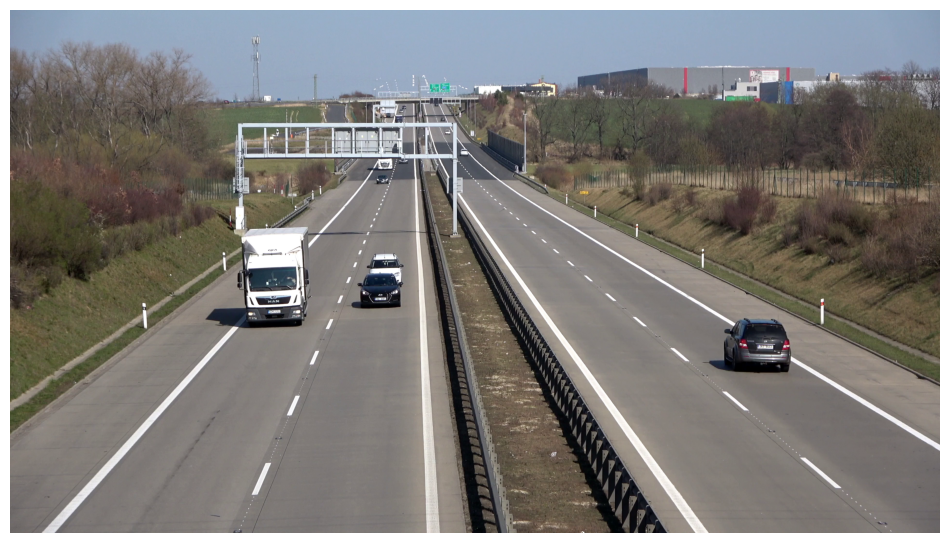

In [7]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(generator)

sv.plot_image(frame, (12, 12))


We can also use [`VideoInfo.from_video_path`](https://supervision.roboflow.com/develop/utils/video/#supervision.utils.video.VideoInfo) to learn basic information about our video, such as duration, resolution, or FPS.

In [8]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

## Run Object Detection

Let's start by running the detection model on the first frame and annotating the results. In this cookbook, we use [Ultralytics](https://github.com/ultralytics/ultralytics) YOLOv8, but it can be successfully replaced with [other models](https://supervision.roboflow.com/latest/detection/core).

We initiate the model and perform detection on the first frame of the video. Then, we convert the result into a [`sv.Detections`](https://supervision.roboflow.com/latest/detection/core/) object, which will be useful in the later parts of the cookbook.

In [7]:
model = YOLO("yolo11x.pt")

results = model(frame, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

100%|██████████| 109M/109M [00:10<00:00, 11.5MB/s] 



The results we've obtained can be easily visualized with [`sv.BoundingBoxAnnotator`](https://supervision.roboflow.com/latest/detection/annotators/#supervision.annotators.core.BoundingBoxAnnotator). By default, this annotator uses the same color to highlight objects of the same category. However, with the integration of a [tracker](https://supervision.roboflow.com/latest/trackers/), it becomes possible to assign unique colors to each tracked object. We can easily define our [own color palettes](https://supervision.roboflow.com/latest/utils/draw/#supervision.draw.color.ColorPalette) and adjust parameters such as line thickness, allowing for a highly tailored visualization experience.

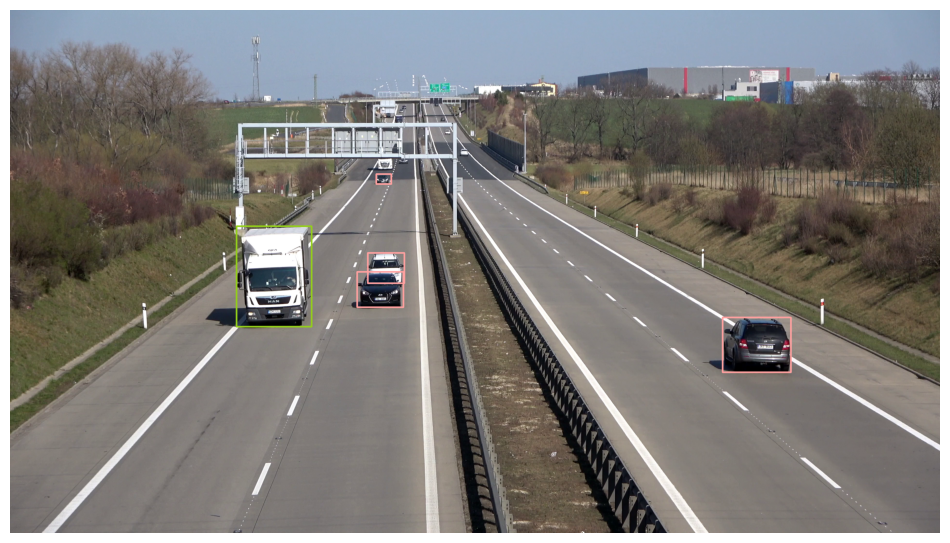

In [10]:
bounding_box_annotator = sv.BoxAnnotator(thickness=6)
annotated_frame = bounding_box_annotator.annotate(frame.copy(), detections)
sv.plot_image(annotated_frame, (12, 12))

## Improve Visualizations

Supervision annotators can be easily combined with one another. Let's enhance our visualization by adding [`sv.LabelAnnotator`](https://supervision.roboflow.com/latest/detection/annotators/#supervision.annotators.core.PolygonAnnotator.annotate), which we will use to mark detections with a label indicating their category and confidence level.

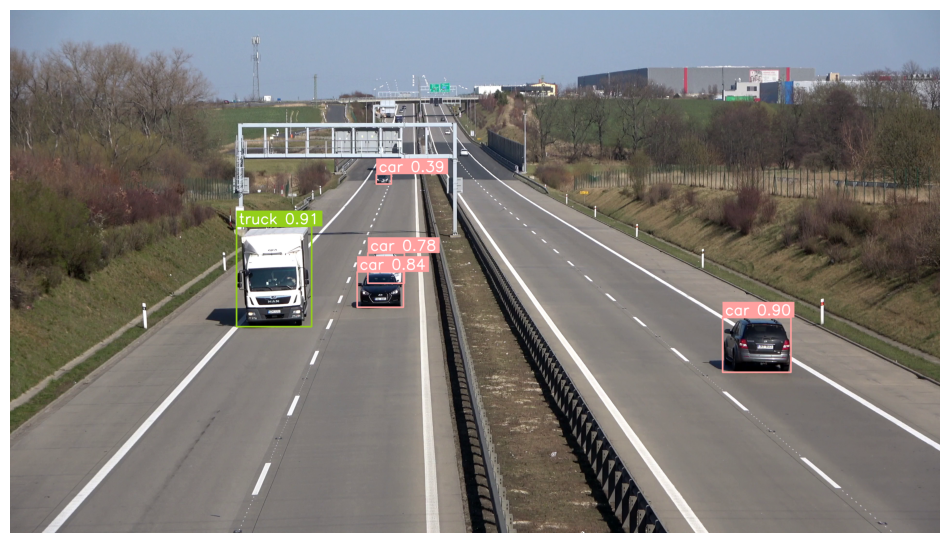

In [11]:
labels = [
    f"{results.names[class_id]} {confidence:0.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

box_annotator = sv.BoxAnnotator(thickness=6)
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)
sv.plot_image(annotated_frame, (12, 12))

## Define Line Position

To set the position of `sv.LineZone`, we need to define the `start` and `end` points. The position of each point is defined as a pair of coordinates `(x, y)`. The origin of the coordinate system is located in the top-left corner of the frame. The `x` axis runs from left to right, and the `y` axis runs from top to bottom.

I decided to place my line horizontally, at the midpoint of the frame's height. I obtained the full dimensions of the frame using [`sv.VideoInfo`](https://supervision.roboflow.com/develop/utils/video/#supervision.utils.video.VideoInfo).


In [14]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

The line we've created, together with the `in_count` and `out_count`, can be elegantly visualized using [`sv.LineZoneAnnotator`](https://supervision.roboflow.com/latest/detection/tools/line_zone/#supervision.detection.line_zone.LineZoneAnnotator). This tool also allows for extensive customization options; we can alter the color of both the line and the text, opt to hide the in/out counts, and adjust the labels. By default, the labels are set to `in` and `out`, but they can be tailored to fit the context of our project, providing a clear and intuitive display of object movement across the designated line.

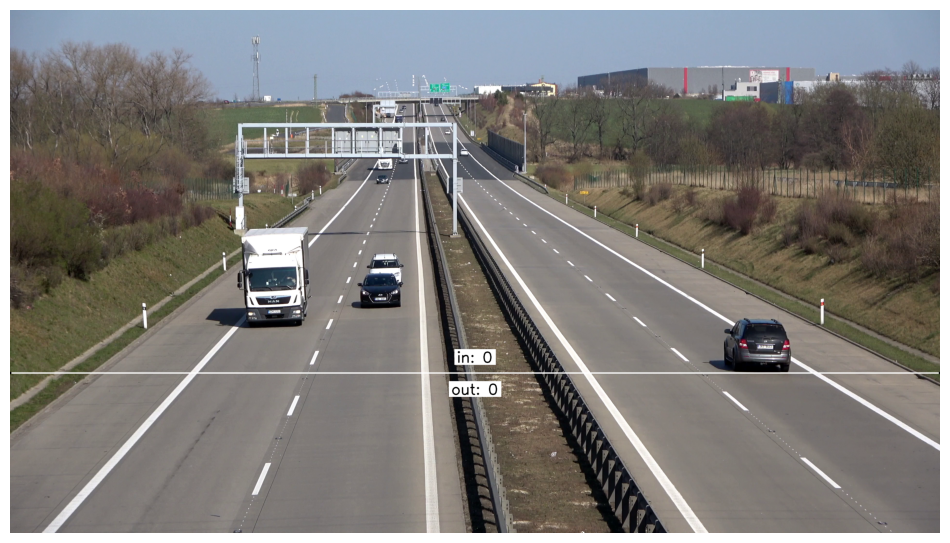

In [22]:
START = sv.Point(0, 1500)
END = sv.Point(3840, 1500)

line_zone = sv.LineZone(start=START, end=END)

line_zone_annotator = sv.LineZoneAnnotator(
    thickness=4,
    text_thickness=4,
    text_scale=2)

annotated_frame = frame.copy()
annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)
sv.plot_image(annotated_frame, (12, 12))

## Process Video

In [18]:
byte_tracker = sv.ByteTrack()

For an even better visualization, we will add another annotator - `sv.TraceAnnotator`, which allows for drawing the path traversed by each object over the last few frames. We will use it in combination with `sv.BoundingBoxAnnotator` and `sv.LabelAnnotator`, which we became familiar with earlier.

In [17]:
bounding_box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)
trace_annotator = sv.TraceAnnotator(thickness=4)

All the operations we plan to perform for each frame of our video - detection, tracking, annotation, and counting - are encapsulated in a function named `callback`.

In [19]:
def callback(frame: np.ndarray, index:int) -> np.ndarray:
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = byte_tracker.update_with_detections(detections)

    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(
        scene=annotated_frame,
        detections=detections)
    annotated_frame = bounding_box_annotator.annotate(
        scene=annotated_frame,
        detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels)

    line_zone.trigger(detections)

    return  line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

Finally, we are ready to process our entire video. We will use [`sv.process_video`](https://supervision.roboflow.com/develop/utils/video/#supervision.utils.video.process_video) and pass to it the previously defined `SOURCE_VIDEO_PATH`, `TARGET_VIDEO_PATH`, and `callback`.

In [21]:
TARGET_VIDEO_PATH = f"{HOME}/count-objects-crossing-the-line-result.mp4"

In [20]:
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)

 Keep in mind that the video preview below works only in the web version of the cookbooks and not in Google Colab.

<video controls>
    <source
        src="https://storage.googleapis.com/com-roboflow-marketing/supervision/cookbooks/count-objects-crossing-the-line-result-1280x720.mp4"
        type="video/mp4"
    >
</video>